### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
allocated_index = pd.read_csv('allocated_index.csv', index_col=0)
allocated_index_returns = pd.read_csv('allocated_index_returns.csv', index_col=0)

### **Potential stock evolution modeled as a Brownian Motion**

In [5]:
summary_stats = rk.summary_stats(allocated_index_returns)
index_mu = summary_stats['Annualized Return']['index']
index_sigma = summary_stats['Annualized Volatility']['index']

(index_mu.round(4), index_sigma.round(4))

(np.float64(0.207), np.float64(0.1455))

In [6]:
cppi_controls = widgets.interactive(rk.show_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50, description='Number of scenarios'),
                                    n_years=widgets.IntSlider(min=1, max=30, step=1, value=10, description='Number of years'),
                                    steps_per_year=widgets.IntSlider(min=1, max=54, step=1, value=12, description='Rebals/year'),
                                    mu=(-.2, .3, .01),
                                    sigma=(0, .6, .01),
                                    floor=(0, 2, .05),
                                    riskfree_rate=(0, .2, .01),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                            description="Zoom Y Axis")
                                   )
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='Number of scenarios', max=1000, min=1, step=5), IntSlid…

### **Develop Drawdown-based CPPI Strategy (Constant Proportion Portfolio Insurance)**

In [7]:
# Run a backtest for the allocated index with a drawdown-based CPPI strategy
drawdown_floor = .2
rf_rate = .12
m = 5

btr = rk.run_cppi(allocated_index_returns, m=m, start=1000, riskfree_rate=rf_rate, drawdown=drawdown_floor)

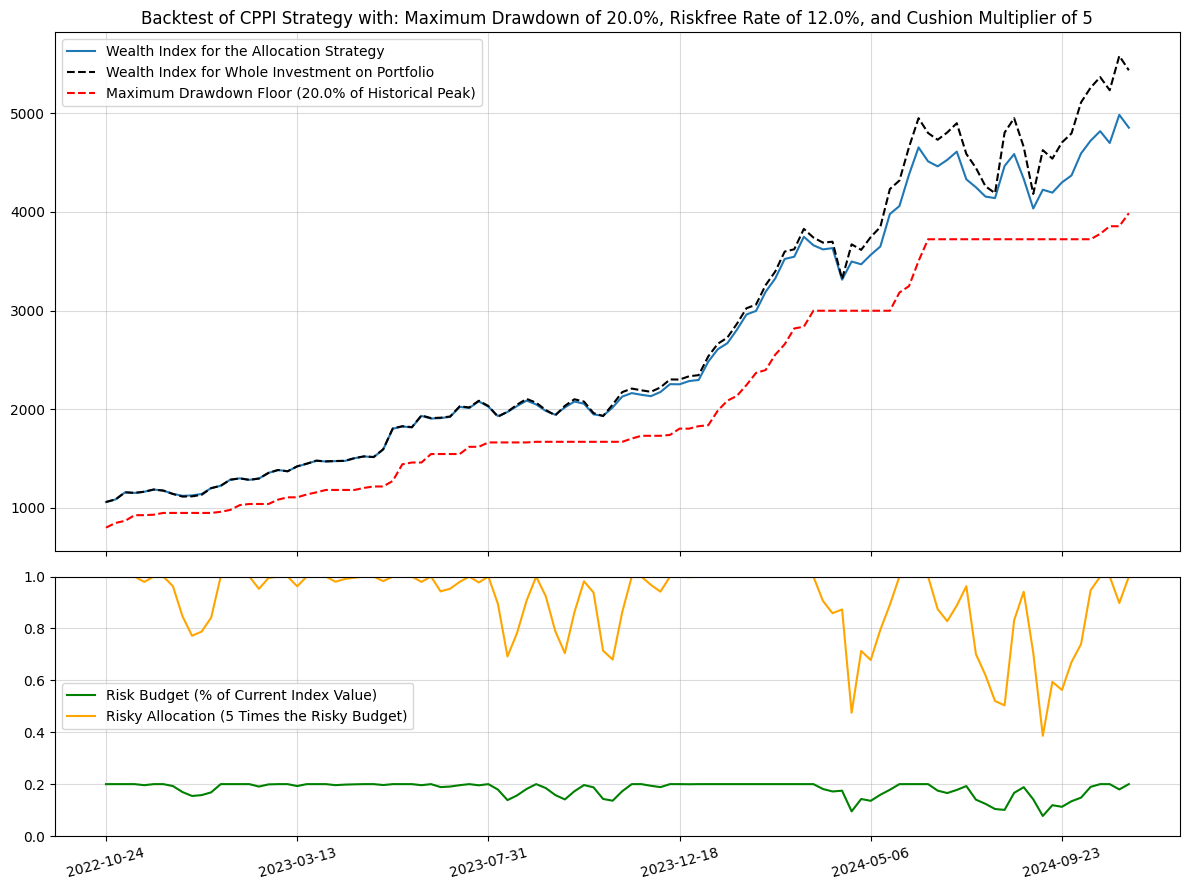

In [8]:
# Visualize the backtest of the CPPI strategy
# First subplot
fig, axes = plt.subplots(2, 1, figsize=(12, 9), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
btr['Wealth']['index'].plot(ax=axes[0], label='Wealth Index for the Allocation Strategy')
btr['Risky Wealth']['index'].plot(ax=axes[0], style='k--', label='Wealth Index for Whole Investment on Portfolio')
btr['floor']['index'].plot(ax=axes[0], color='r', linestyle='--', label=f'Maximum Drawdown Floor ({drawdown_floor*100}% of Historical Peak)')

# Second subplot
btr['Risk Budget']['index'].plot(ax=axes[1], color='g', label='Risk Budget (% of Current Index Value)')
btr['Risky Allocation']['index'].plot(ax=axes[1], color='orange', label=f'Risky Allocation ({m} Times the Risky Budget)')



axes[0].set_title(f'Backtest of CPPI Strategy with: Maximum Drawdown of {drawdown_floor*100}%, Riskfree Rate of {rf_rate*100}%, and Cushion Multiplier of {m}')

axes[0].legend()
axes[1].legend()

axes[0].grid(alpha=.45)
axes[1].grid(alpha=.45)

axes[1].set_ylim(0, 1)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### **Recommended Allocation based on last week**

In [9]:
weights = (allocated_index.iloc[0]/allocated_index['index'][0]).drop('index', axis='index')
investment = 42180000 # Current money available for investment in COP

stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights
safe_allocation = (1 - btr['Risky Allocation']['index'][-1])*investment

C:\Users\jumar\AppData\Local\Temp\ipykernel_10840\1811659486.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = (allocated_index.iloc[0]/allocated_index['index'][0]).drop('index', axis='index')
C:\Users\jumar\AppData\Local\Temp\ipykernel_10840\1811659486.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights
C:\Users\jumar\AppData\Local\Temp\ipykernel_10840\1811659486.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

In [10]:
(stocks_allocation/1000).round(2)

CEMARGOS.CL       5155.67
MINEROS.CL        2650.39
NUTRESA.CL        2082.75
PFGRUPOARG.CL     3593.60
TERPEL.CL         2488.21
CENCOSUD.SN       4156.97
IUFS.CL           5522.71
JPM               1591.94
NVDA             14937.77
Name: 2022-10-23, dtype: float64

In [11]:
(safe_allocation/1000).round(2)

np.float64(0.0)

In [12]:
# Allocation if all budget went to the risky investment

stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights + (1 - btr['Risky Allocation']['index'][-1])*investment*weights
(stocks_allocation/1000).round(2)

C:\Users\jumar\AppData\Local\Temp\ipykernel_10840\1100804839.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights + (1 - btr['Risky Allocation']['index'][-1])*investment*weights


CEMARGOS.CL       5155.67
MINEROS.CL        2650.39
NUTRESA.CL        2082.75
PFGRUPOARG.CL     3593.60
TERPEL.CL         2488.21
CENCOSUD.SN       4156.97
IUFS.CL           5522.71
JPM               1591.94
NVDA             14937.77
Name: 2022-10-23, dtype: float64